In [1]:
from math import factorial
from scipy.stats import beta
from skfda.misc import inner_product, inner_product_matrix
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FourierBasis, FDataBasis
import matplotlib.pyplot as plt
import numpy as np

In [253]:
# Define the data
sample_size = 3
n_basis = 7
if n_basis % 2 == 0:
    n_basis = n_basis + 1
ones_sample_size = np.ones(shape=(sample_size, 1))
ones_n_basis = np.ones(shape=(n_basis, 1))
domain_range = (0, 1)
period = 1
x_basis = FourierBasis(n_basis=n_basis, domain_range=domain_range, period=period)
np.random.seed(123)
normal_sample = np.random.normal(size=(sample_size, n_basis))
coefficients_exp = np.array([1/(2 ** i) for i in range(1, n_basis + 1)]).reshape(1, -1)
coefficients_exp_matrix = np.dot(ones_sample_size, coefficients_exp)
coefficients = np.multiply(normal_sample, coefficients_exp_matrix)

In [254]:
covariate = FDataBasis(basis=x_basis, coefficients=coefficients)

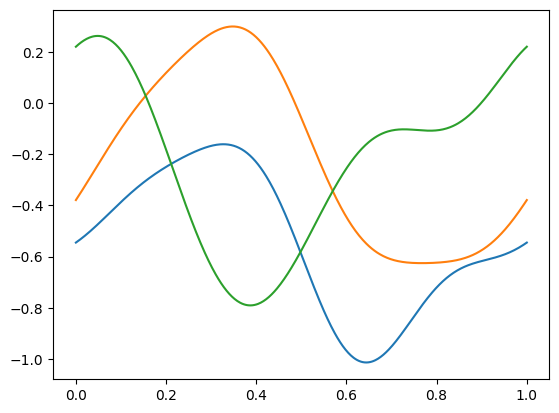

In [255]:
n_plot = covariate.plot()

In [256]:
# Beta distribution
cnt = 20
alpha_1 =  1 * cnt
beta_1 = 4 * cnt
rv_1 = beta(alpha_1, beta_1)

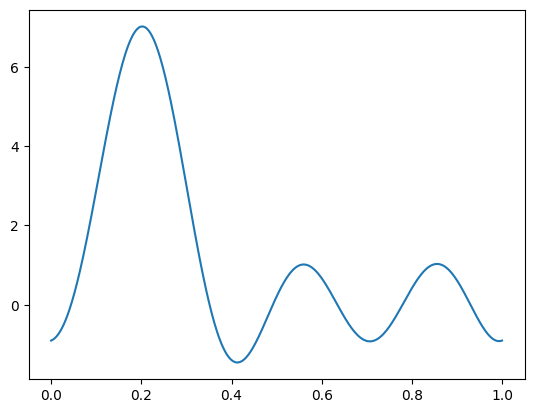

In [257]:
# Transfor beta to fda object
n_points_abscissa_axis = 11
distance_between_points = (domain_range[1] - domain_range[0])/(n_points_abscissa_axis-1)
abscissa_points = np.arange(domain_range[0], domain_range[1] + distance_between_points, distance_between_points)
f_x = rv_1.pdf(abscissa_points)
beta_fda = FDataBasis.from_data(
    data_matrix=f_x,
    grid_points=abscissa_points,
    basis=x_basis
)
n_plot = beta_fda.plot()

In [258]:
# Exploring the beta representation
print(beta_fda.coefficients)

[[ 1.16161616  1.43058011  0.55976035  0.80536269 -1.06573677 -0.84532223
  -0.95185627]]


0.01725712121031751


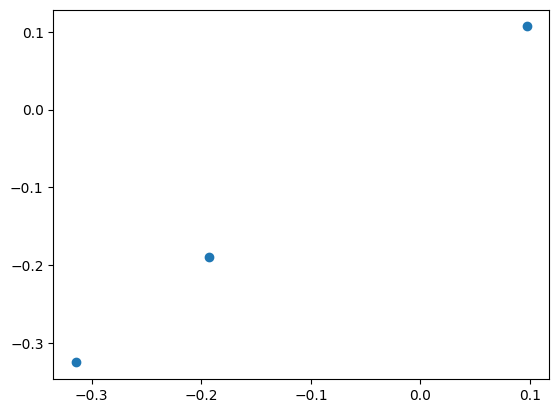

In [259]:
# Getting target variable
ration_signal_noise = 0.01
mx = inner_product(covariate, beta_fda)
var_mx = np.var(mx)
np.random.seed(123)
scale_noise = np.sqrt(ration_signal_noise * var_mx)
error_y = np.random.normal(size=sample_size, loc = 0, scale=ration_signal_noise)
print(scale_noise)
y = mx + error_y
plt.plot(mx, y, 'o')

FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 1.0),), n_basis=7, period=1),
    coefficients=[[ 1.00974539  0.29588712 -0.50010906  0.14736637  0.0458234  -0.00276913
       0.0430847 ]])


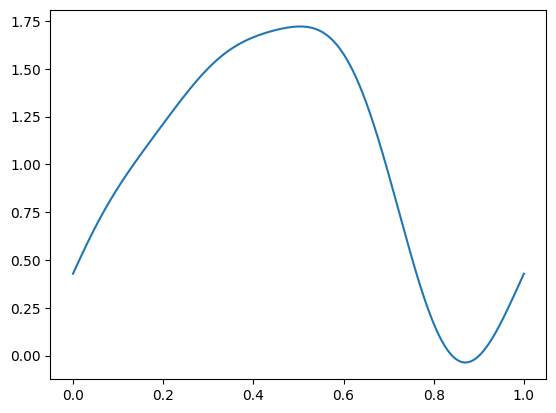

In [260]:
# Fit the model
linear_reg = LinearRegression()
_ = linear_reg.fit(covariate, y)
beta_estimated = linear_reg.coef_[0]
print(beta_estimated)
n_plot = beta_estimated.plot()

In [261]:
# Predict
print(linear_reg.predict(covariate))
print(y)

[-0.32522015  0.10700245 -0.18998428]
[-0.32522015  0.10700245 -0.18998428]


In [262]:
# Creating data for the algorithm
X = covariate(abscissa_points)
print(X.shape)
X_copy = np.squeeze(X)
print(X_copy.shape)

(3, 11, 1)
(3, 11)


In [263]:
# Input of the algorithm
print(X_copy)
print(abscissa_points)
predict_fn = linear_reg.predict

[[-0.54517333 -0.3866166  -0.24932892 -0.16711284 -0.23088218 -0.59159879
  -0.96806284 -0.95144149 -0.72062924 -0.61730679 -0.54517333]
 [-0.37892034 -0.1001733   0.11832229  0.27213639  0.25751588 -0.05836346
  -0.44546364 -0.61100334 -0.62373576 -0.57487786 -0.37892034]
 [ 0.22048623  0.20636367 -0.18143266 -0.63647929 -0.78721763 -0.57572153
  -0.2552688  -0.10712506 -0.10652204  0.0030073   0.22048623]]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [542]:
# initial validations
class ShapleyFda:
    def __init__(self, predict_fn, X, abscissa_points, target, domain_rage, verbose, debug):
        self.predict_fn = predict_fn
        self.X = X
        self.abscissa_points = abscissa_points
        self.target = target
        self.domain_range = domain_rage
        self.verbose = verbose
        # TODO delete all debug
        self.debug = debug

    # TODO
    def validations(self, num_intervals, set_intervals):
        pass

    def create_set_intervals(self, num_intervals, intervals):
        if num_intervals is None and intervals is None:
            raise ValueError("Either num_intervals or intervals must not be None")
        elif num_intervals:
            ini_domain_range = self.domain_range[0]
            end_domain_range = self.domain_range[1]
            long_domain_range = end_domain_range - ini_domain_range
            h = (long_domain_range)/num_intervals
            intervals_lower_bound = np.arange(ini_domain_range, end_domain_range, h)
            intervals_upper_bound = np.arange(ini_domain_range + h, end_domain_range + h, h)
            intervals = np.stack((intervals_lower_bound, intervals_upper_bound), axis=1)
        elif intervals:
            # TODO: if the user provides intervals, standardise it so that
            # it has the same shape as if it were created by the previous statement
            pass
        return intervals

    def create_permutations(self, num_intervals, num_permutations):
        set_permutations = set()
        total_set_permutations = len(set_permutations)
        # Error when impossible number of permutations is desired
        if num_permutations > factorial(num_intervals):
            raise ValueError("num_permutations can no be greater than the factorial of number of intervals")
        # Iterate until the desired number of permutations is obtained
        while total_set_permutations < num_permutations:
            new_permutation = np.random.choice(a=num_intervals, size=num_intervals, replace=False)
            new_permutation = tuple(new_permutation)
            set_permutations.add(new_permutation)
            total_set_permutations = len(set_permutations)
        return set_permutations

    def fn_real(self):
        def inner_fn_real(set_abscissa_points):
            f_points = np.full(shape=(self.X.shape[0], set_abscissa_points.shape[0]), fill_value=0)
            return f_points
        fn_to_return = self.compute_f
        if self.debug:
            fn_to_return = inner_fn_real
        return fn_to_return

    def fn_constant(self):
        def inner_fn_constant(set_abscissa_points):
            if (isinstance(set_abscissa_points, int) or isinstance(set_abscissa_points, float)):
                set_abscissa_points = np.array([set_abscissa_points])
            mean_val = np.mean(self.X, axis=1, keepdims=True)
            vector_ones = np.ones(shape=(1, set_abscissa_points.shape[0]))
            f_points = np.dot(mean_val, vector_ones)
            return f_points
        return inner_fn_constant

    def fn_linear(self, abscissa_ini, abscissa_end):
        def inner_fn_linear(set_abscissa_points):
            return None
        return inner_fn_linear

    def break_permutation(self, permutation, global_interval_position, use_interval):
        interval_position_inside_permutation = np.argwhere(global_interval_position == permutation).squeeze()
        # Given the permutation, some we will have to interpolate the information for some of the intervals.
        # Depending if the current interval is used or not.
        if use_interval:
            available_intervals = permutation[:(interval_position_inside_permutation + 1)]
            non_available_intervals = permutation[(interval_position_inside_permutation + 1):]
        else:
            available_intervals = permutation[:interval_position_inside_permutation]
            non_available_intervals = permutation[interval_position_inside_permutation:]
        return available_intervals, non_available_intervals

    def build_interpolation_fn(self, intervals, labels):
        num_unique_intervals = np.max(intervals)
        return [self.fn_real for _ in range(intervals.shape[0])]
    
    def map_function_interval(self, intervals):
        # Check if there are consecutive intervals
        labels_intervals = np.empty(shape=intervals.shape, dtype=intervals.dtype)
        sorting_positions = np.argsort(intervals)
        sorted_intervals = intervals[sorting_positions]
        i_interval = 0
        label_interval = 0
        previous_interval = None
        for interval in sorted_intervals:
            # Two intervals are not consecutive if the difference between their indexes
            # is greater than 1. We consider that the previous interval to the first one is
            # the void set. Therefore, the first set will always be different from the
            # previous one.
            if ((previous_interval is None) or ((interval - previous_interval) > 1)):
                label_interval += 1
            labels_intervals[i_interval] = label_interval
            previous_interval = interval
            i_interval += 1
        print("\t\tunique_intervals:", labels_intervals)
        # Build the function for each of the (sorted) interval
        sorted_set_fns = self.build_interpolation_fn(sorted_intervals, labels_intervals)
        set_fns = [sorted_set_fns[i] for i in sorting_positions]
        return [(interval, fn) for (interval, fn) in zip(intervals, set_fns)]

    def recompute_covariate(self, set_intervals, global_interval_position, permutation, use_interval):
        recomputed_covariate = np.empty(shape=self.X.shape)
        permutation_array = np.array(permutation)
        # Break the permutation into two parts:
            # first part is the one we are allowed to use
            # second part is the one to be interpolated, i.e, non-available information
        available_intervals, non_available_intervals = self.break_permutation(permutation_array, global_interval_position, use_interval)
        self.print(
            "\t\tuse_interval:", use_interval,
            "\tavailable_intervals:", available_intervals, 
            "\tnon_available_intervals:", non_available_intervals
        )
        # For the available_intervals we will use real values.
        # This must be a list of tuples.
        fun_available_intervals = [(x, self.fn_real) for x in available_intervals]
        # This must be a list of tuples.
        fun_non_available_intervals = self.map_function_interval(non_available_intervals)
        print("\t\tfun_available_intervals", fun_available_intervals)
        print("\t\tfun_non_available_intervals", fun_non_available_intervals, "\n")
        return recomputed_covariate

    def compute_interval_relevance(self, set_intervals, set_permutations, interval_position):
        num_intervals = set_intervals.shape[0]
        # For each permutation
        for i_permutation in set_permutations:
            # Recreate the feature (return a set of two covariates)
            covariate_no_interval = self.recompute_covariate(set_intervals, interval_position, i_permutation, use_interval = False)
            covariate_interval = self.recompute_covariate(set_intervals, interval_position, i_permutation, use_interval = True)
            # Retrain the model with the first feature and obtain R^2
            # Retrain the model with the second feature and obtain R^2
            # Compute the differnece of R^2
            # Stack the difference
        # Compute the mean value
        return 1

    def compute_f(self, set_abscissa_points):
        if (isinstance(set_abscissa_points, int) or isinstance(set_abscissa_points, float)):
            set_abscissa_points = np.array([set_abscissa_points])
        i_point = 0
        f_points = np.empty(shape=(self.X.shape[0], set_abscissa_points.shape[0]))
        for point in set_abscissa_points:
            if (point < self.domain_range[0] or point > self.domain_range[1]):
                raise ValueError("points contains a point outside the domain range (domain_range)")
            min_position = np.max(np.argwhere(point >= self.abscissa_points))
            num_min = self.abscissa_points[min_position]
            if (np.abs(num_min - point) < 1e-7):
                f_points[:, i_point] = self.X[:, min_position]
            else:
                max_position = np.min(np.argwhere(point < self.abscissa_points))
                num_max = self.abscissa_points[max_position]
                w_min = 1 - (point - num_min)/(num_max - num_min)
                w_max = 1 - (num_max - point)/(num_max - num_min)
                f_min = self.X[:, min_position]
                f_max = self.X[:, max_position]
                f_eval_point = w_min * f_min + w_max * f_max
                f_points[:, i_point] = f_eval_point
            i_point += 1
        return f_points

    def eval_function_set_intervals(self, set_intervals):
        set_intervals_shape = set_intervals.shape
        new_shape = [x for x in set_intervals_shape]
        new_shape.insert(0, self.X.shape[0])
        f_set_intervals = np.empty(shape=new_shape)
        ini = set_intervals[:, 0]
        end = set_intervals[:, 1]
        f_ini = self.compute_f(ini)
        f_end = self.compute_f(end)
        n_intervals = set_intervals_shape[0]
        for i_interval in range(n_intervals):
            f_set_intervals[:, i_interval, 0] = f_ini[:, i_interval]
            f_set_intervals[:, i_interval, 1] = f_end[:, i_interval]
        return f_set_intervals
    
    def print(self, *args):
        if self.verbose:
            str_print = ""
            for arg in args:
                str_print = str_print + " " + str(arg)
            print(str_print)

    def compute_shapley_value(self, num_permutations, num_intervals=None, intervals=None):
        # Create a set of intervals: 
        #       we will treat all the intervals as [a, b), 
        #       except for the las one, which will be [a, b]
        set_intervals = self.create_set_intervals(num_intervals, intervals)
        self.print("set_intervals:\n", set_intervals)
        # Eval the function at each bound of the intervals
        f_set_intervals = self.eval_function_set_intervals(set_intervals)
        self.print("\nf_set_intervals:\n", f_set_intervals)
        # Perform validations
        self.validations(num_intervals, set_intervals)
        num_intervals = set_intervals.shape[0] if num_intervals is None else num_intervals
        # Get the set of permutations
        set_permutations = self.create_permutations(num_intervals=num_intervals, num_permutations=num_permutations)
        self.print("\nset_permutations:\n", set_permutations)
        # For each interval, compute the relevance
        intervals_relevance = []
        if self.debug:
            num_intervals = 1
        for i_interval in range(num_intervals):
            interval = set_intervals[i_interval]
            self.print("\tComputing relevance for interval:", interval, "whose index is", i_interval)
            relevance = self.compute_interval_relevance(set_intervals, set_permutations, i_interval)
            result = [interval, relevance]
            intervals_relevance.append(result)
        return intervals_relevance

In [544]:
shapley_fda = ShapleyFda(
    predict_fn=predict_fn,
    X=X_copy,
    abscissa_points=abscissa_points,
    target=y,
    domain_rage=domain_range,
    verbose=True,
    debug=True,
)
values_shap = shapley_fda.compute_shapley_value(num_intervals=5, num_permutations=1)
#print("relevance:\n", values_shap, "\n")

 set_intervals:
 [[0.  0.2]
 [0.2 0.4]
 [0.4 0.6]
 [0.6 0.8]
 [0.8 1. ]]
 
f_set_intervals:
 [[[-0.54517333 -0.24932892]
  [-0.24932892 -0.23088218]
  [-0.23088218 -0.96806284]
  [-0.96806284 -0.72062924]
  [-0.72062924 -0.54517333]]

 [[-0.37892034  0.11832229]
  [ 0.11832229  0.25751588]
  [ 0.25751588 -0.44546364]
  [-0.44546364 -0.62373576]
  [-0.62373576 -0.37892034]]

 [[ 0.22048623 -0.18143266]
  [-0.18143266 -0.78721763]
  [-0.78721763 -0.2552688 ]
  [-0.2552688  -0.10652204]
  [-0.10652204  0.22048623]]]
 
set_permutations:
 {(2, 1, 0, 3, 4)}
 	Computing relevance for interval: [0.  0.2] whose index is 0
 		use_interval: False 	available_intervals: [2 1] 	non_available_intervals: [0 3 4]
		unique_intervals: [1 2 2]
		fun_available_intervals [(2, <bound method ShapleyFda.fn_real of <__main__.ShapleyFda object at 0x12b880e50>>), (1, <bound method ShapleyFda.fn_real of <__main__.ShapleyFda object at 0x12b880e50>>)]
		fun_non_available_intervals [(0, <bound method ShapleyFda.fn_re

In [539]:
zzz = shapley_fda.fn_constant()
zzz(np.array([2, 3, 5, 7,8 ]))

array([[-0.54302967, -0.54302967, -0.54302967, -0.54302967, -0.54302967],
       [-0.22940759, -0.22940759, -0.22940759, -0.22940759, -0.22940759],
       [-0.18176578, -0.18176578, -0.18176578, -0.18176578, -0.18176578]])

In [415]:
a = np.array([0., 0.3, 0.4])
b = np.array([0.33333333, 0.66666667, 1.])
idx = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
f_idx = 2 * idx
idx == 0

array([ True, False, False, False, False, False])

In [531]:
my_num = np.array([0, 0.1, 0.9])
mean_val = np.mean(X_copy, axis=1, keepdims=True)
vector_ones = np.ones(shape=(1, my_num.shape[0]))

print(np.dot(mean_val, vector_ones))

[[-0.54302967 -0.54302967 -0.54302967]
 [-0.22940759 -0.22940759 -0.22940759]
 [-0.18176578 -0.18176578 -0.18176578]]
